## Data loading and preparation




In [ ]:
from google.colab import drive
import os
import zipfile
import glob

# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Define the base path to the dataset directory in Google Drive
#    Replace 'Dataset directory in google drive folder' with the actual folder name
gdrive_base_path = '/content/drive/My Drive/cse427 dataset'

# 3. Define the names of the zip files
phishing_zip_name = 'phishing_0001-0500.zip'
not_phishing_zip_name = 'not-phishing_0001-0500.zip'

# 4. Construct the full paths to the zip files
phishing_zip_path = os.path.join(gdrive_base_path, phishing_zip_name)
not_phishing_zip_path = os.path.join(gdrive_base_path, not_phishing_zip_name)

# 5. Create a local directory within the Colab environment for extraction
extracted_dir_base = '/content/extracted_dataset'
os.makedirs(extracted_dir_base, exist_ok=True)

# Define extraction paths
phishing_extract_dir = os.path.join(extracted_dir_base, 'phishing')
not_phishing_extract_dir = os.path.join(extracted_dir_base, 'not-phishing')

# 6. Extract the contents of the phishing zip file
print(f"Extracting {phishing_zip_name}...")
with zipfile.ZipFile(phishing_zip_path, 'r') as zip_ref:
    zip_ref.extractall(phishing_extract_dir)
print("Extraction complete.")

# 7. Extract the contents of the not-phishing zip file
print(f"Extracting {not_phishing_zip_name}...")
with zipfile.ZipFile(not_phishing_zip_path, 'r') as zip_ref:
    zip_ref.extractall(not_phishing_extract_dir)
print("Extraction complete.")

# 8. & 9. Traverse the extracted directories and collect file paths
dataset_instances = []

def collect_file_paths(base_dir, label):
    for instance_dir in os.listdir(base_dir):
        instance_path = os.path.join(base_dir, instance_dir)
        if os.path.isdir(instance_path):
            instance_data = {
                'label': label,
                'instance_dir': instance_path,
                'screenshot_path': None,
                'html_path': None,
                'css_paths': [],
                'metadata_path': None
            }

            # Collect file paths within the instance directory
            for root, _, files in os.walk(instance_path):
                for file in files:
                    file_path = os.path.join(root, file)
                    if file.endswith(('.png', '.jpg')):
                        instance_data['screenshot_path'] = file_path
                    elif file.endswith('.html'):
                        instance_data['html_path'] = file_path
                    elif file.endswith('.css'):
                        instance_data['css_paths'].append(file_path)
                    elif file.endswith('.json'):
                        instance_data['metadata_path'] = file_path

            dataset_instances.append(instance_data)

# Collect paths for phishing instances
collect_file_paths(phishing_extract_dir, 'phishing')

# Collect paths for not-phishing instances
collect_file_paths(not_phishing_extract_dir, 'not-phishing')

# 10. dataset_instances list now contains all collected data
print(f"Collected data for {len(dataset_instances)} instances.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Extracting phishing_0001-0500.zip...
Extraction complete.
Extracting not-phishing_0001-0500.zip...
Extraction complete.
Collected data for 1000 instances.


## Data exploration and preprocessing

Visualizing missing value percentages:


/tmp/ipython-input-608267398.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing_percentages.index, y=missing_percentages.values, palette='viridis')


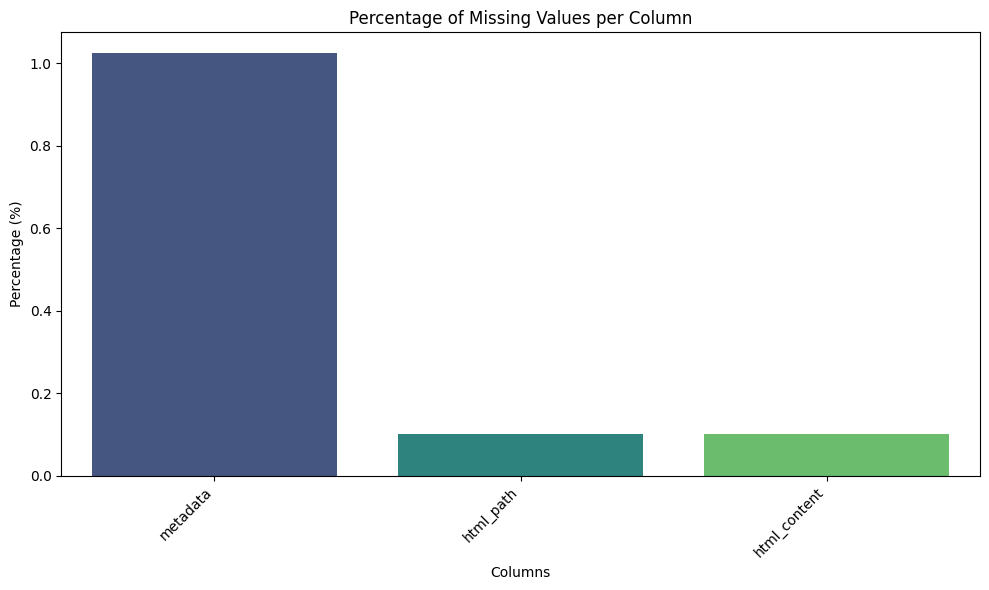


Visualizing the distribution of the 'label' column:


/tmp/ipython-input-608267398.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette='viridis')


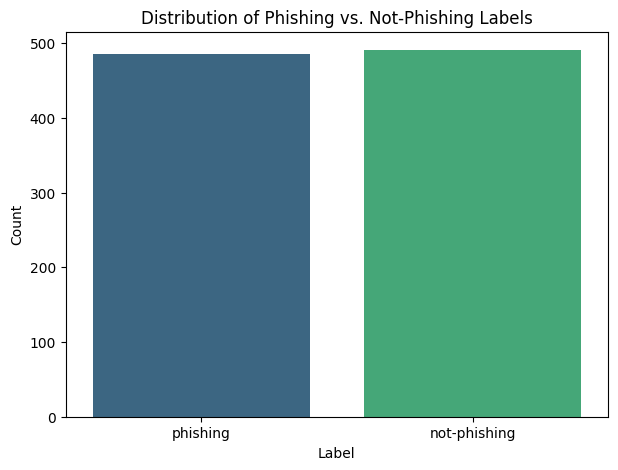

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming df is available from the data loading and preparation step

# Visualize missing value percentages
print("Visualizing missing value percentages:")
missing_percentages = df.isnull().mean() * 100
missing_percentages = missing_percentages[missing_percentages > 0].sort_values(ascending=False)

if not missing_percentages.empty:
    plt.figure(figsize=(10, 6))
    sns.barplot(x=missing_percentages.index, y=missing_percentages.values, palette='viridis')
    plt.title('Percentage of Missing Values per Column')
    plt.ylabel('Percentage (%)')
    plt.xlabel('Columns')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("No missing values found in the DataFrame.")

# Visualize the distribution of the 'label' column
print("\nVisualizing the distribution of the 'label' column:")
plt.figure(figsize=(7, 5))
sns.countplot(x='label', data=df, palette='viridis')
plt.title('Distribution of Phishing vs. Not-Phishing Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import json
import os

# 1. Import the pandas library and create a DataFrame named df from the dataset_instances list.
# Assuming dataset_instances is available from the previous step
df = pd.DataFrame(dataset_instances)

# 2. Display the first 5 rows of the DataFrame and its data types using .head() and .info().
print("First 5 rows of the DataFrame:")
display(df.head())

print("\nDataFrame info:")
df.info()

# 3. Print the total number of samples in the DataFrame and the value counts of the 'label' column.
print(f"\nTotal number of samples: {len(df)}")
print("\nDistribution of the 'label' column:")
display(df['label'].value_counts())

# 4. Calculate and print the percentage of missing values for the 'screenshot_path', 'html_path', 'css_paths', and 'metadata_path' columns.
missing_percentages = df[['screenshot_path', 'html_path', 'css_paths', 'metadata_path']].isnull().mean() * 100
print("\nPercentage of missing values:")
display(missing_percentages)

First 5 rows of the DataFrame:


,label,instance_dir,screenshot_path,html_path,css_paths,metadata_path
0,phishing,/content/extracted_dataset/phishing/640db76388...,/content/extracted_dataset/phishing/640db76388...,/content/extracted_dataset/phishing/640db76388...,[/content/extracted_dataset/phishing/640db7638...,/content/extracted_dataset/phishing/640db76388...
1,phishing,/content/extracted_dataset/phishing/640c456356...,/content/extracted_dataset/phishing/640c456356...,/content/extracted_dataset/phishing/640c456356...,[/content/extracted_dataset/phishing/640c45635...,/content/extracted_dataset/phishing/640c456356...
2,phishing,/content/extracted_dataset/phishing/640d8b3688...,/content/extracted_dataset/phishing/640d8b3688...,/content/extracted_dataset/phishing/640d8b3688...,[/content/extracted_dataset/phishing/640d8b368...,/content/extracted_dataset/phishing/640d8b3688...
3,phishing,/content/extracted_dataset/phishing/640c8d8156...,/content/extracted_dataset/phishing/640c8d8156...,/content/extracted_dataset/phishing/640c8d8156...,[/content/extracted_dataset/phishing/640c8d815...,/content/extracted_dataset/phishing/640c8d8156...
4,phishing,/content/extracted_dataset/phishing/640fa99888...,/content/extracted_dataset/phishing/640fa99888...,/content/extracted_dataset/phishing/640fa99888...,[/content/extracted_dataset/phishing/640fa9988...,/content/extracted_dataset/phishing/640fa99888...



DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   label            1000 non-null   object
 1   instance_dir     1000 non-null   object
 2   screenshot_path  1000 non-null   object
 3   html_path        999 non-null    object
 4   css_paths        1000 non-null   object
 5   metadata_path    1000 non-null   object
dtypes: object(6)
memory usage: 47.0+ KB

Total number of samples: 1000

Distribution of the 'label' column:


,count
label,
phishing,500
not-phishing,500



Percentage of missing values:


,0
screenshot_path,0.0
html_path,0.1
css_paths,0.0
metadata_path,0.0


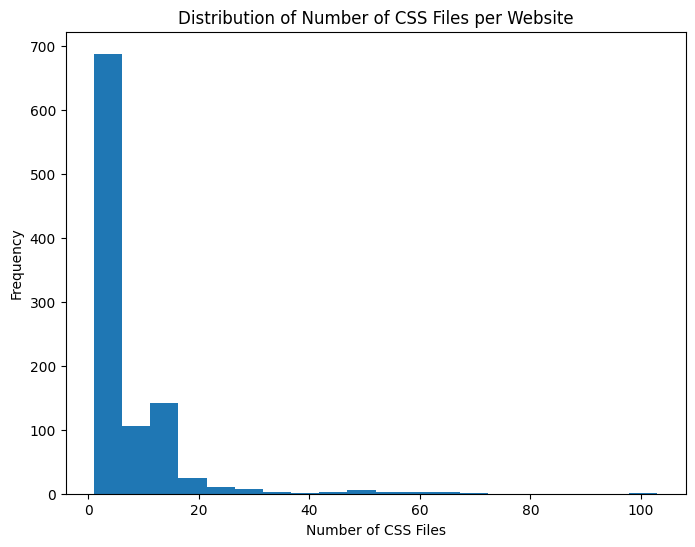

Loading screenshot images...
Error loading screenshot (unidentified format): /content/extracted_dataset/phishing/641a1d77069ca95ac7e6acbb/assets/loader-57.png
Error loading screenshot (unidentified format): /content/extracted_dataset/phishing/640d477b88abc709fe610b5a/assets/ato-logo-white-vertical-0.png
Error loading screenshot (unidentified format): /content/extracted_dataset/phishing/640be16d563822ede6be78e8/assets/social-media_youtube@3x.png
Error loading screenshot (unidentified format): /content/extracted_dataset/phishing/640c9f08563822ede6be7b07/assets/ico-arrow2.png
Error loading screenshot (unidentified format): /content/extracted_dataset/phishing/640c9fc6563822ede6be7b12/assets/ico-arrow2.png
Error loading screenshot (unidentified format): /content/extracted_dataset/phishing/640d0647563822ede6be7c75/assets/ico-arrow2.png
Error loading screenshot (unidentified format): /content/extracted_dataset/phishing/640bdca1563822ede6be7800/assets/flags@2x.png
Error loading screenshot (uni

In [ ]:
# 5. Create a new column named 'num_css_files' in df by applying a function to the 'css_paths' column that returns the length of the list in each row.
df['num_css_files'] = df['css_paths'].apply(len)

# 6. Visualize the distribution of the 'num_css_files' column using a histogram.
plt.figure(figsize=(8, 6))
df['num_css_files'].hist(bins=20)
plt.title('Distribution of Number of CSS Files per Website')
plt.xlabel('Number of CSS Files')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()

# 7. Define a function load_screenshot that takes a file path, opens the image using PIL's Image.open, and returns the image object, handling potential FileNotFoundError and other exceptions by returning None.
from PIL import UnidentifiedImageError # Import the specific error

def load_screenshot(file_path):
    if file_path is None:
        return None
    # Added check for image file extensions
    if not file_path.lower().endswith(('.png', '.jpg', '.jpeg')):
        # Removed the print statement here to reduce clutter, as these are expected non-image files
        return None
    try:
        img = Image.open(file_path)
        return img
    except FileNotFoundError:
        print(f"Screenshot file not found: {file_path}")
        return None
    except UnidentifiedImageError:
        # Catch specific error for unidentifiable image files
        print(f"Error loading screenshot (unidentified format): {file_path}")
        return None
    except Exception as e:
        print(f"Error loading screenshot {file_path}: {e}")
        return None

# 8. Apply the load_screenshot function to the 'screenshot_path' column of df to create a new column named 'screenshot_image'.
print("Loading screenshot images...")
df['screenshot_image'] = df['screenshot_path'].apply(load_screenshot)
print("Screenshot loading complete.")

# 9. Define a function read_text_file that takes a file path and an optional encoding, reads the file content, and returns it as a string, handling potential FileNotFoundError, encoding errors, and other exceptions by returning None.
def read_text_file(file_path, encoding='utf-8'):
    if file_path is None or not os.path.exists(file_path):
        return None
    try:
        with open(file_path, 'r', encoding=encoding) as f:
            content = f.read()
        return content
    except FileNotFoundError:
        # This case is handled by the os.path.exists check, but included for clarity
        print(f"Text file not found: {file_path}")
        return None
    except UnicodeDecodeError:
        # Try a different common encoding if utf-8 fails
        try:
            with open(file_path, 'r', encoding='latin-1') as f:
                content = f.read()
            return content
        except Exception as e:
            print(f"Encoding error reading {file_path}: {e}")
            return None
    except Exception as e:
        print(f"Error reading text file {file_path}: {e}")
        return None

# 10. Apply the read_text_file function to the 'html_path' column of df to create a new column named 'html_content'.
print("Loading HTML content...")
df['html_content'] = df['html_path'].apply(read_text_file)
print("HTML loading complete.")

# 11. Define a function read_and_concatenate_css that takes a list of CSS file paths, reads the content of each file using the read_text_file function, concatenates them into a single string with a separator (e.g., a newline), and returns the concatenated string, handling cases where the input list is empty or contains only None values by returning None.
def read_and_concatenate_css(css_paths):
    if not css_paths:
        return None
    all_css_content = []
    for css_path in css_paths:
        content = read_text_file(css_path)
        if content:
            all_css_content.append(content)

    if not all_css_content:
        return None
    return "\n".join(all_css_content)


# 12. Apply the read_and_concatenate_css function to the 'css_paths' column of df to create a new column named 'css_content'.
print("Loading and concatenating CSS content...")
df['css_content'] = df['css_paths'].apply(read_and_concatenate_css)
print("CSS loading complete.")

# 13. Define a function load_json_file that takes a file path, reads the JSON content, and returns the parsed Python object (e.g., dictionary), handling potential FileNotFoundError, JSON decoding errors, and other exceptions by returning None.
def load_json_file(file_path):
    if file_path is None or not os.path.exists(file_path):
        return None
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
        return data
    except FileNotFoundError:
        # This case is handled by the os.path.exists check, but included for clarity
        return None
    except json.JSONDecodeError:
        print(f"JSON decoding error for {file_path}")
        return None
    except Exception as e:
        print(f"Error loading JSON file {file_path}: {e}")
        return None

# 14. Apply the load_json_file function to the 'metadata_path' column of df to create a new column named 'metadata'.
print("Loading metadata...")
df['metadata'] = df['metadata_path'].apply(load_json_file)
print("Metadata loading complete.")

Removed 23 rows with unidentifiable screenshot images.
Remaining rows in the DataFrame: 977
Extracting screenshot dimensions...
Screenshot dimensions extracted.

Distribution of 'brand' in metadata:
No 'brand' information found in metadata.

Calculating content lengths...
Content lengths calculated.


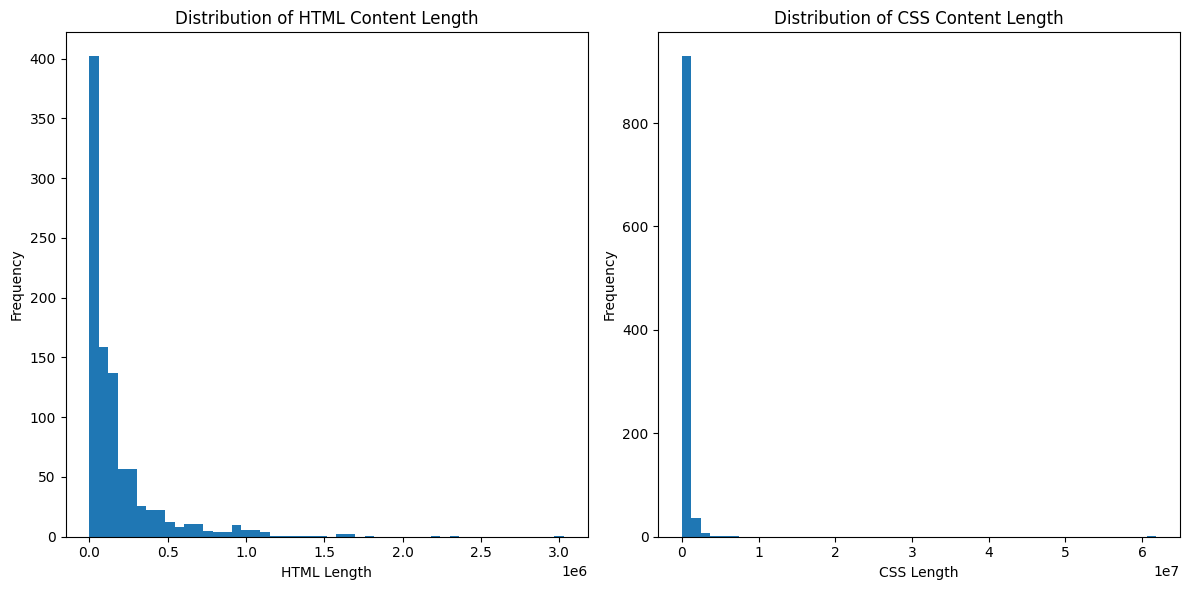

In [ ]:
# 15. Define a function get_image_dimensions that takes an image object (from PIL), and if the image object is not None, returns a tuple of its width and height; otherwise, returns (None, None).
def get_image_dimensions(image):
    if image:
        try:
            return image.size
        except Exception as e:
            print(f"Error getting image dimensions: {e}")
            return (None, None)
    return (None, None)

# Filter out rows where screenshot_image is None to permanently remove them
initial_rows = len(df)
df = df[df['screenshot_image'].notna()].reset_index(drop=True)
print(f"Removed {initial_rows - len(df)} rows with unidentifiable screenshot images.")
print(f"Remaining rows in the DataFrame: {len(df)}")

# 16. Apply the get_image_dimensions function to the 'screenshot_image' column of df to create two new columns, 'screenshot_width' and 'screenshot_height', from the returned tuples.
print("Extracting screenshot dimensions...")
df[['screenshot_width', 'screenshot_height']] = df['screenshot_image'].apply(get_image_dimensions).apply(pd.Series)
print("Screenshot dimensions extracted.")

# 17. Calculate the value counts of the 'brand' key within the 'metadata' column, considering only rows where 'metadata' is not None and the 'brand' key exists, and display the top few brands if available.
print("\nDistribution of 'brand' in metadata:")
# Filter out rows where metadata is None or not a dictionary or does not have the 'brand' key
brand_counts = df[df['metadata'].apply(lambda x: isinstance(x, dict) and 'brand' in x)]['metadata'].apply(lambda x: x.get('brand')).value_counts()

if not brand_counts.empty:
    display(brand_counts.head())
else:
    print("No 'brand' information found in metadata.")


# 18. Calculate the string length of the 'html_content' and 'css_content' columns, storing them in new columns named 'html_length' and 'css_length' respectively. Handle None values by assigning a length of 0.
print("\nCalculating content lengths...")
df['html_length'] = df['html_content'].apply(lambda x: len(x) if isinstance(x, str) else 0)
df['css_length'] = df['css_content'].apply(lambda x: len(x) if isinstance(x, str) else 0)
print("Content lengths calculated.")

# 19. Visualize the distributions of 'html_length' and 'css_length' using histograms.
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
df['html_length'].hist(bins=50)
plt.title('Distribution of HTML Content Length')
plt.xlabel('HTML Length')
plt.ylabel('Frequency')
plt.grid(False)

plt.subplot(1, 2, 2)
df['css_length'].hist(bins=50)
plt.title('Distribution of CSS Content Length')
plt.xlabel('CSS Length')
plt.ylabel('Frequency')
plt.grid(False)

plt.tight_layout()
plt.show()

## Feature extraction

### Subtask:
Implement multimodal feature extraction, including visual features from screenshots using VGG16, textual features from HTML and CSS using basic features and TF-IDF (and optionally DistilBERT embeddings), and cross-modal features. Combine all features into a single DataFrame and handle missing values.


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model
import re
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import pandas as pd
from PIL import Image
import io

# Download necessary NLTK data if not already present
try:
    nltk.data.find('tokenizers/punkt')
except LookupError: # Corrected exception type
    print("NLTK 'punkt' tokenizer not found. Downloading...")
    nltk.download('punkt')
    print("Download complete.")

In [ ]:
# Download necessary NLTK data if not already present
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    print("NLTK 'punkt' tokenizer not found. Downloading...")
    nltk.download('punkt')
    print("Download complete.")


Loading the pre-trained VGG16 model without the top classification layer and define the visual feature extraction function.



In [ ]:
# 2. Load the VGG16 model pre-trained on 'imagenet', excluding the top layer.
#    Add GlobalAveragePooling2D to get a fixed-size feature vector.
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
visual_feature_model = Model(inputs=base_model.input, outputs=x)

# 3. Define a function extract_visual_features
def extract_visual_features(image):

    if image is None:
        return None
    try:
        # Preprocess the image for VGG16
        # Ensure image is RGB
        if image.mode != 'RGB':
            image = image.convert('RGB')
        # Resize image to the input size expected by VGG16
        image = image.resize((224, 224))
        # Convert the image to a numpy array
        image_array = np.array(image)
        # Expand dimensions to create a batch of 1
        image_array = np.expand_dims(image_array, axis=0)
        # Apply VGG16 preprocessing (scaling, etc.)
        image_array = vgg16_preprocess_input(image_array)

        # Extract features
        features = visual_feature_model.predict(image_array, verbose=0)
        return features.flatten() # Flatten the features to a 1D array
    except Exception as e:
        print(f"Error extracting visual features: {e}")
        return None

Applying the `extract_visual_features` function to the 'screenshot_image' column and convert the results into a DataFrame.



In [ ]:
# 4. Apply the extract_visual_features function to the 'screenshot_image' column.
print("Extracting visual features from screenshots...")
visual_features = df['screenshot_image'].apply(extract_visual_features)

# Convert the list of feature arrays into a DataFrame.
# Handle None values which indicate failed feature extraction.
visual_features_list = visual_features.tolist()
# Filter out None values before creating DataFrame
valid_features = [f for f in visual_features_list if f is not None]

if valid_features:
    visual_features_df = pd.DataFrame(valid_features, index=visual_features[visual_features.notna()].index)
    print(f"Extracted visual features with shape: {visual_features_df.shape}")
else:
    visual_features_df = pd.DataFrame()
    print("No valid visual features extracted.")

# Add placeholder rows with NaNs for instances where feature extraction failed
if len(visual_features_df) < len(df):
    all_indices = df.index
    extracted_indices = visual_features_df.index
    missing_indices = all_indices.difference(extracted_indices)
    if not missing_indices.empty:
        # Create a DataFrame of NaNs with the correct number of columns for missing indices
        num_features = visual_features_df.shape[1] if not visual_features_df.empty else 512 # VGG16 GAP output size
        missing_df = pd.DataFrame(np.nan, index=missing_indices, columns=range(num_features))
        visual_features_df = pd.concat([visual_features_df, missing_df]).sort_index()


display(visual_features_df.head())

Extracting visual features from screenshots...


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Extracted visual features with shape: (977, 512)


,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,0.0,0.000000,0.000000,0.019776,0.000000,0.0,0.174309,0.000000,0.00000,0.000000,...,0.961288,0.315830,0.000000,0.000000,0.032615,0.000000,0.000000,0.000000,0.006919,0.000000
1,0.0,0.000000,0.852869,0.000000,3.525665,0.0,6.464659,0.441941,0.00000,0.000000,...,0.000000,0.441234,0.000000,0.157117,1.118383,2.032442,0.000000,0.898282,0.857757,3.387886
2,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,...,0.162414,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.0,0.000000,0.397448,0.000000,3.559420,0.0,1.459667,2.515471,0.65211,4.254784,...,0.000000,0.326749,0.000000,0.868095,0.000000,0.000000,2.163208,0.189917,0.000000,6.001583
4,0.0,0.128486,0.000000,0.000000,0.960353,0.0,0.353216,2.844294,0.00000,0.093013,...,0.866692,1.122694,0.052551,1.630158,0.062020,0.040951,1.460991,0.000000,0.660974,0.000000


applying the function to extract basic textual features from HTML and CSS content.



In [ ]:
# 5. Define a function extract_basic_text_features
def extract_basic_text_features(content, content_type):
    """
    Extracts basic features from text content (HTML or CSS).

    Args:
        content: A string of text content (HTML or CSS) or None.
        content_type: 'html' or 'css' to indicate the type of content.

    Returns:
        A dictionary of basic features.
    """
    features = {
        f'{content_type}_length': 0,
        f'{content_type}_num_lines': 0,
    }

    if isinstance(content, str):
        features[f'{content_type}_length'] = len(content)
        features[f'{content_type}_num_lines'] = content.count('\n') + 1

        if content_type == 'html':
            # Basic HTML tag counts (example: script and link tags)
            features['html_num_script_tags'] = len(re.findall(r'<script', content, re.IGNORECASE))
            features['html_num_link_tags'] = len(re.findall(r'<link', content, re.IGNORECASE))
        elif content_type == 'css':
            # Basic CSS rule/import counts (example: @import and rule blocks {})
            features['css_num_imports'] = len(re.findall(r'@import', content, re.IGNORECASE))
            features['css_num_rules'] = len(re.findall(r'{.*?}', content, re.DOTALL)) # Simple rule count

    return features

# 6. Apply the extract_basic_text_features function
print("Extracting basic textual features...")
html_basic_features = df['html_content'].apply(lambda x: extract_basic_text_features(x, 'html'))
css_basic_features = df['css_content'].apply(lambda x: extract_basic_text_features(x, 'css'))

# Convert the list of dictionaries into DataFrames
html_basic_features_df = pd.DataFrame(html_basic_features.tolist(), index=df.index)
css_basic_features_df = pd.DataFrame(css_basic_features.tolist(), index=df.index)

print("Basic textual features extracted.")
display(html_basic_features_df.head())
display(css_basic_features_df.head())

Extracting basic textual features...
Basic textual features extracted.


,html_length,html_num_lines,html_num_script_tags,html_num_link_tags
0,8763,184,2.0,1.0
1,6297,237,9.0,2.0
2,1130,61,0.0,0.0
3,725087,509,10.0,2.0
4,384239,8567,52.0,14.0


,css_length,css_num_lines,css_num_imports,css_num_rules
0,6141,340,0,47
1,159850,242,0,2342
2,172844,7460,0,2048
3,4317,256,0,46
4,347883,2090,1,3012


applying TF-IDF vectorization to the HTML and CSS content to extract TF-IDF features, handling missing values and converting to DataFrames.



In [ ]:
# 7. Initialize a TF-IDF Vectorizer
# Use a limited number of features to keep the feature matrix size manageable
tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')

# 8. Apply TF-IDF Vectorizer to HTML content
print("Extracting HTML TF-IDF features...")
# Replace None with empty string for TF-IDF vectorization
html_content_cleaned = df['html_content'].fillna('')
html_tfidf_features = tfidf_vectorizer.fit_transform(html_content_cleaned)

# Convert the sparse matrix to a DataFrame
html_tfidf_features_df = pd.DataFrame(html_tfidf_features.toarray(), index=df.index)
print(f"HTML TF-IDF features extracted with shape: {html_tfidf_features_df.shape}")
display(html_tfidf_features_df.head())

# 9. Apply the same TF-IDF Vectorizer to CSS content
# Note: Using the same vectorizer might not be ideal for CSS, but for simplicity
# we will reuse it. In a real scenario, a separate vectorizer or different approach
# might be better for CSS.
print("Extracting CSS TF-IDF features...")
# Replace None with empty string for TF-IDF vectorization
css_content_cleaned = df['css_content'].fillna('')
css_tfidf_features = tfidf_vectorizer.fit_transform(css_content_cleaned) # Fit and transform separately for CSS vocabulary

# Convert the sparse matrix to a DataFrame
css_tfidf_features_df = pd.DataFrame(css_tfidf_features.toarray(), index=df.index)
print(f"CSS TF-IDF features extracted with shape: {css_tfidf_features_df.shape}")
display(css_tfidf_features_df.head())

Extracting HTML TF-IDF features...
HTML TF-IDF features extracted with shape: (977, 1000)


,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.0,0.138259,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.228180,0.0,0.0,0.000000,0.0,0.000000,0.022344,0.000000,0.000000,0.0
1,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
2,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
3,0.0,0.012259,0.001588,0.000238,0.0,0.0,0.0,0.0,0.0,0.0,...,0.002908,0.0,0.0,0.059417,0.0,0.005079,0.004359,0.000840,0.000000,0.0
4,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.046953,0.0,0.0,0.018106,0.0,0.000000,0.000000,0.011043,0.008272,0.0


Extracting CSS TF-IDF features...
CSS TF-IDF features extracted with shape: (977, 1000)


,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.058243,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.017601
1,0.022955,0.000000,0.001324,0.000672,0.001208,0.000939,0.0,0.0,0.000000,0.000000,...,0.0,0.142369,0.0,0.012159,0.014323,0.000000,0.254832,0.0,0.0,0.000000
2,0.007907,0.000000,0.000000,0.000000,0.000000,0.002245,0.0,0.0,0.003015,0.007544,...,0.0,0.000000,0.0,0.000000,0.000000,0.055479,0.000000,0.0,0.0,0.002137
3,0.016942,0.030169,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
4,0.013707,0.000000,0.000864,0.000000,0.000000,0.002144,0.0,0.0,0.005266,0.002316,...,0.0,0.000000,0.0,0.001190,0.000000,0.030938,0.000000,0.0,0.0,0.001166


**Reasoning**:
Define and apply the function to extract cross-modal features and then concatenate all extracted features into a single DataFrame, handling missing values.



In [ ]:
# 11. Define a function extract_cross_modal_features
def extract_cross_modal_features(row):
    """
    Extracts cross-modal features from DataFrame row data.

    Args:
        row: A pandas Series representing a row in the DataFrame.

    Returns:
        A dictionary of cross-modal features.
    """
    html_len = row['html_length'] if pd.notna(row['html_length']) else 0
    css_len = row['css_length'] if pd.notna(row['css_length']) else 0
    num_css = row['num_css_files'] if pd.notna(row['num_css_files']) else 0

    features = {
        'css_to_html_length_ratio': css_len / html_len if html_len > 0 else 0,
        'avg_css_file_length': css_len / num_css if num_css > 0 else 0,
        # Add other potential cross-modal features here
        'screenshot_html_width_ratio': row['screenshot_width'] / html_len if html_len > 0 and pd.notna(row['screenshot_width']) else 0,
        'screenshot_css_width_ratio': row['screenshot_width'] / css_len if css_len > 0 and pd.notna(row['screenshot_width']) else 0,
    }
    return features

# 12. Apply the extract_cross_modal_features function
print("Extracting cross-modal features...")
cross_modal_features = df.apply(extract_cross_modal_features, axis=1)

# Convert the list of dictionaries into a DataFrame
cross_modal_features_df = pd.DataFrame(cross_modal_features.tolist(), index=df.index)
print("Cross-modal features extracted.")
display(cross_modal_features_df.head())

# 13. Concatenate all extracted feature DataFrames
print("Combining all features...")
# Ensure all dataframes have the same index before concatenation
# visual_features_df already has the correct index from step 4
# html_basic_features_df, css_basic_features_df, html_tfidf_features_df,
# css_tfidf_features_df, and cross_modal_features_df were created with df.index

all_features_df = pd.concat([
    visual_features_df,
    html_basic_features_df,
    css_basic_features_df,
    html_tfidf_features_df,
    css_tfidf_features_df,
    cross_modal_features_df
], axis=1)

print(f"Combined feature matrix shape: {all_features_df.shape}")
display(all_features_df.head())

# 14. Handle any remaining missing values in the combined feature matrix
print("Handling missing values in the combined feature matrix...")
# Use mean imputation as a simple strategy. Consider median or a constant value
# depending on feature distributions and domain knowledge.
all_features_df = all_features_df.fillna(all_features_df.mean())
print("Missing values handled.")
display(all_features_df.head())

# The subtask is completed.

Extracting cross-modal features...
Cross-modal features extracted.


,css_to_html_length_ratio,avg_css_file_length,screenshot_html_width_ratio,screenshot_css_width_ratio
0,0.700787,6141.000000,0.019742,0.028171
1,25.385104,79925.000000,0.171510,0.006756
2,152.959292,28807.333333,0.096460,0.000631
3,0.005954,4317.000000,0.002648,0.444753
4,0.905382,26760.230769,0.000351,0.000388


Combining all features...
Combined feature matrix shape: (977, 2524)


,0,1,2,3,4,5,6,7,8,9,...,994,995,996,997,998,999,css_to_html_length_ratio,avg_css_file_length,screenshot_html_width_ratio,screenshot_css_width_ratio
0,0.0,0.000000,0.000000,0.019776,0.000000,0.0,0.174309,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.017601,0.700787,6141.000000,0.019742,0.028171
1,0.0,0.000000,0.852869,0.000000,3.525665,0.0,6.464659,0.441941,0.00000,0.000000,...,0.014323,0.000000,0.254832,0.0,0.0,0.000000,25.385104,79925.000000,0.171510,0.006756
2,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.055479,0.000000,0.0,0.0,0.002137,152.959292,28807.333333,0.096460,0.000631
3,0.0,0.000000,0.397448,0.000000,3.559420,0.0,1.459667,2.515471,0.65211,4.254784,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.005954,4317.000000,0.002648,0.444753
4,0.0,0.128486,0.000000,0.000000,0.960353,0.0,0.353216,2.844294,0.00000,0.093013,...,0.000000,0.030938,0.000000,0.0,0.0,0.001166,0.905382,26760.230769,0.000351,0.000388


Handling missing values in the combined feature matrix...
Missing values handled.


,0,1,2,3,4,5,6,7,8,9,...,994,995,996,997,998,999,css_to_html_length_ratio,avg_css_file_length,screenshot_html_width_ratio,screenshot_css_width_ratio
0,0.0,0.000000,0.000000,0.019776,0.000000,0.0,0.174309,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.017601,0.700787,6141.000000,0.019742,0.028171
1,0.0,0.000000,0.852869,0.000000,3.525665,0.0,6.464659,0.441941,0.00000,0.000000,...,0.014323,0.000000,0.254832,0.0,0.0,0.000000,25.385104,79925.000000,0.171510,0.006756
2,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.055479,0.000000,0.0,0.0,0.002137,152.959292,28807.333333,0.096460,0.000631
3,0.0,0.000000,0.397448,0.000000,3.559420,0.0,1.459667,2.515471,0.65211,4.254784,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.005954,4317.000000,0.002648,0.444753
4,0.0,0.128486,0.000000,0.000000,0.960353,0.0,0.353216,2.844294,0.00000,0.093013,...,0.000000,0.030938,0.000000,0.0,0.0,0.001166,0.905382,26760.230769,0.000351,0.000388


## Model selection



## Data splitting and scaling

Split data into training and testing sets using stratified sampling and scale numerical features using StandardScaler.


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd # Ensure pandas is imported

# 2. Define features X and target y
X = all_features_df
y = df['label']

# Convert all column names in X to strings
X.columns = X.columns.astype(str)

# Convert the 'label' column to numerical format (0 for 'not-phishing', 1 for 'phishing')
y_numeric = y.map({'not-phishing': 0, 'phishing': 1})

# 3. Split the data into training and testing sets
print("Splitting data into training and testing sets...")
X_train, X_test, y_train_numeric, y_test_numeric = train_test_split(
    X, y_numeric, test_size=0.25, random_state=42, stratify=y_numeric
)
print("Data splitting complete.")
print(f"Training set shape: {X_train.shape}, {y_train_numeric.shape}")
print(f"Testing set shape: {X_test.shape}, {y_test_numeric.shape}")

# 4. Initialize a StandardScaler
scaler = StandardScaler()

# 5. Fit the scaler to the training features and transform both training and testing features
print("Scaling numerical features...")
# Ensure column names are preserved after scaling for easy identification later
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)
print("Feature scaling complete.")
display(X_train_scaled.head())
display(X_test_scaled.head())

# 6. Identify and handle potential columns with zero variance in X_train_scaled
print("Identifying and removing zero-variance columns...")
# Calculate variance for each column in the scaled training data
variances = X_train_scaled.var()

# Find columns with variance very close to zero (floating point comparison)
zero_variance_columns = variances[variances < 1e-9].index.tolist()

if zero_variance_columns:
    print(f"Found {len(zero_variance_columns)} zero-variance columns: {zero_variance_columns}")
    # Remove these columns from both training and testing scaled dataframes
    X_train_scaled = X_train_scaled.drop(columns=zero_variance_columns)
    X_test_scaled = X_test_scaled.drop(columns=zero_variance_columns)
    print("Zero-variance columns removed from training and testing sets.")
    print(f"Training set shape after removing zero-variance columns: {X_train_scaled.shape}")
    print(f"Testing set shape after removing zero-variance columns: {X_test_scaled.shape}")
else:
    print("No zero-variance columns found.")

# The subtask is completed.

Splitting data into training and testing sets...
Data splitting complete.
Training set shape: (732, 2524), (732,)
Testing set shape: (245, 2524), (245,)
Scaling numerical features...
Feature scaling complete.


,0,1,2,3,4,5,6,7,8,9,...,994,995,996,997,998,999,css_to_html_length_ratio,avg_css_file_length,screenshot_html_width_ratio,screenshot_css_width_ratio
299,-0.277673,-0.252513,-0.307119,-0.166898,-0.484657,-0.345593,-0.513907,-0.344544,-0.216811,-0.245436,...,-0.295427,-0.345173,-0.184364,-0.051486,-0.043223,-0.309944,-0.078589,-0.531060,-0.109113,7.826598
5,-0.277673,-0.252513,-0.307119,-0.166898,-0.357977,-0.125889,-0.513907,-0.344544,-0.216811,-0.245436,...,-0.295427,-0.345173,-0.184364,-0.051486,-0.043223,-0.309944,-0.077969,-0.510393,0.151579,0.195988
662,-0.277673,-0.252513,-0.307119,-0.166898,-0.484657,-0.345593,-0.513907,-0.344544,-0.216811,-0.245436,...,0.040414,-0.299546,-0.184364,-0.051486,-0.043223,-0.309944,-0.074345,0.146027,-0.160342,-0.148019
925,-0.277673,-0.164870,-0.151283,-0.155293,-0.484657,1.451289,-0.513907,-0.212371,0.433434,-0.245436,...,-0.295427,11.649544,-0.184364,-0.051486,-0.043223,-0.309944,-0.076764,0.739030,-0.160249,-0.147840
253,-0.070334,2.212408,0.866974,0.116239,-0.100762,2.536019,2.433099,-0.344544,-0.216811,0.150966,...,-0.295427,-0.345173,-0.184364,-0.051486,-0.043223,-0.309944,-0.078306,-0.522988,-0.157400,-0.139499


,0,1,2,3,4,5,6,7,8,9,...,994,995,996,997,998,999,css_to_html_length_ratio,avg_css_file_length,screenshot_html_width_ratio,screenshot_css_width_ratio
959,-0.277673,-0.252513,2.920706,-0.138396,-0.411558,-0.345593,1.460634,0.906033,2.306990,0.419849,...,-0.295427,2.560799,-0.184364,-0.051486,-0.043223,0.151100,-0.072594,-0.047573,-0.021134,-0.132093
940,-0.243396,-0.252513,-0.307119,-0.166898,1.656272,-0.266037,-0.312665,-0.065735,9.308576,1.032254,...,-0.177545,1.258823,-0.184364,-0.051486,-0.043223,0.707977,-0.058444,0.700420,0.023864,-0.141817
409,-0.130109,-0.252513,-0.307119,-0.166898,-0.439248,-0.345593,-0.513907,-0.290702,-0.216811,0.009566,...,-0.295427,-0.345173,-0.184364,-0.051486,-0.043223,-0.309944,-0.078574,-0.354897,-0.158514,-0.060729
652,-0.277673,-0.252513,1.411731,-0.166898,2.237489,-0.180652,2.306363,0.089295,-0.216811,-0.245436,...,-0.295427,-0.345173,-0.184364,-0.051486,-0.043223,-0.097200,-0.078314,-0.456025,-0.157660,-0.139878
759,-0.277673,-0.252513,-0.307119,-0.166898,-0.484657,-0.345593,-0.513907,-0.344544,-0.216811,-0.245436,...,-0.014245,-0.340031,-0.184364,-0.051486,-0.043223,-0.183484,-0.075791,-0.050191,-0.160777,-0.148069


Identifying and removing zero-variance columns...
Found 9 zero-variance columns: ['194', '370', '580', '219', '283', '495', '574', '582', '761']
Zero-variance columns removed from training and testing sets.
Training set shape after removing zero-variance columns: (732, 2501)
Testing set shape after removing zero-variance columns: (245, 2501)


## Model implementation and training



In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import lightgbm as lgb
from sklearn.svm import SVC


**Neural Network model.**

In [ ]:
# Train a basic Neural Network model
print("Implementing and training Neural Network model...")
nn_model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid') # Output layer for binary classification
])

nn_model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

# Train the model
# Use a small number of epochs and batch size for demonstration
nn_model.fit(X_train_scaled, y_train_numeric, epochs=15, batch_size=32, verbose=0)
print("Neural Network model training complete.")

Implementing and training Neural Network model...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Neural Network model training complete.


**LightBGM**

In [ ]:
# Train a LightGBM classifier
print("Implementing and training LightGBM model...")
lgbm_model = lgb.LGBMClassifier(random_state=42)

# Check for and handle duplicate column names
cols = pd.Series(X_train_scaled.columns)
for dup in cols[cols.duplicated()].unique():
    cols[cols[cols == dup].index.values.tolist()] = [dup + '_' + str(i) if i != 0 else dup for i, i in enumerate(cols[cols == dup].index.values.tolist())]
X_train_scaled.columns = cols
X_test_scaled.columns = cols # Apply the same column names to the test set

# Train the model
lgbm_model.fit(X_train_scaled, y_train_numeric)
print("LightGBM model training complete.")

Implementing and training LightGBM model...
[LightGBM] [Info] Number of positive: 364, number of negative: 368
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 303482
[LightGBM] [Info] Number of data points in the train set: 732, number of used features: 2325
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497268 -> initscore=-0.010929
[LightGBM] [Info] Start training from score -0.010929
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

**XGBoost**

In [ ]:
import xgboost as xgb

# Train an XGBoost classifier
print("Implementing and training XGBoost model...")
xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)


xgb_model.fit(X_train_scaled, y_train_numeric)
print("XGBoost model training complete.")

# The trained model is stored in xgb_model
print("\nTrained model: xgb_model")

Implementing and training XGBoost model...
XGBoost model training complete.

Trained model: xgb_model


## Model evaluation



In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

Evaluating Neural Network model...


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Evaluating LightGBM model...
Evaluating XGBoost model...

--- Neural Network Evaluation ---
Accuracy: 0.9224
Precision (Phishing): 0.9328
Recall (Phishing): 0.9098
F1-Score (Phishing): 0.9212


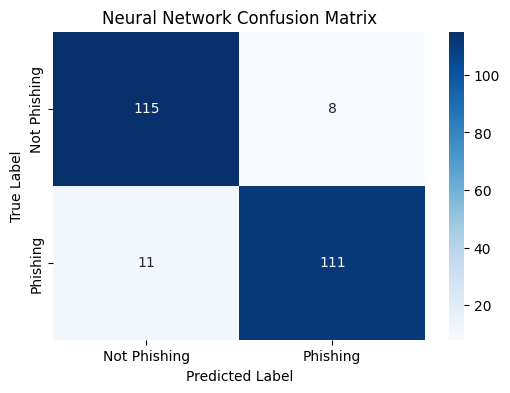


--- LightGBM Evaluation ---
Accuracy: 0.9347
Precision (Phishing): 0.9492
Recall (Phishing): 0.9180
F1-Score (Phishing): 0.9333


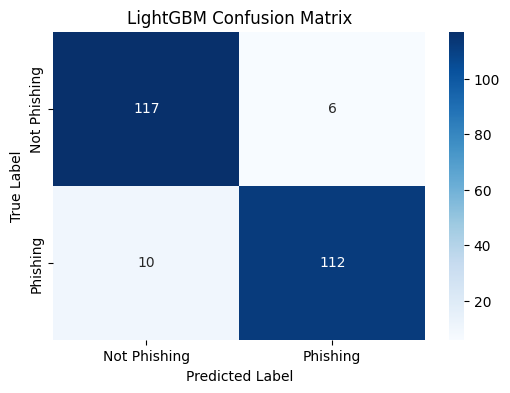


--- XGBoost Evaluation ---
Accuracy: 0.9306
Precision (Phishing): 0.9412
Recall (Phishing): 0.9180
F1-Score (Phishing): 0.9295


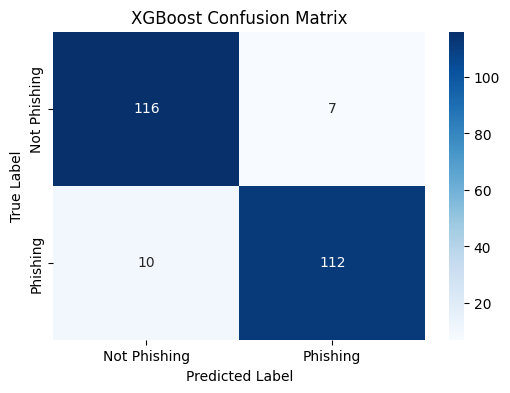


--- Model Performance Summary ---


,Model,Accuracy,Precision (Phishing),Recall (Phishing),F1-Score (Phishing)
0,Neural Network,0.922449,0.932773,0.909836,0.921162
1,LightGBM,0.934694,0.949153,0.918033,0.933333
2,XGBoost,0.930612,0.941176,0.918033,0.929461


In [ ]:
# 2a. Make predictions on the scaled test set for each model
print("Evaluating Neural Network model...")
# Predictions are probabilities, convert to binary (0 or 1)
nn_predictions = (nn_model.predict(X_test_scaled) > 0.5).astype("int32")

print("Evaluating LightGBM model...")
lgbm_predictions = lgbm_model.predict(X_test_scaled)

# print("Evaluating SVM model...")
# svm_predictions = svm_model.predict(X_test_scaled)

print("Evaluating XGBoost model...")
xgb_predictions = xgb_model.predict(X_test_scaled)


# Store metrics for summary table
metrics_data = []
models = {
    "Neural Network": (nn_predictions, 'nn_model'),
    "LightGBM": (lgbm_predictions, 'lgbm_model'),
    # "SVM": (svm_predictions, 'svm_model'),
    "XGBoost": (xgb_predictions, 'xgb_model') # Added XGBoost
}

# 2b, 2c, 2d. Calculate and print metrics, generate and display confusion matrix
for model_name, (predictions, model_var_name) in models.items():
    print(f"\n--- {model_name} Evaluation ---")

    # Calculate metrics
    accuracy = accuracy_score(y_test_numeric, predictions)
    # Calculate precision, recall, f1-score for the 'phishing' class (label 1)
    precision = precision_score(y_test_numeric, predictions, pos_label=1)
    recall = recall_score(y_test_numeric, predictions, pos_label=1)
    f1 = f1_score(y_test_numeric, predictions, pos_label=1)

    # Print metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (Phishing): {precision:.4f}")
    print(f"Recall (Phishing): {recall:.4f}")
    print(f"F1-Score (Phishing): {f1:.4f}")

    # Store metrics for the summary table
    metrics_data.append({
        "Model": model_name,
        "Accuracy": accuracy,
        "Precision (Phishing)": precision,
        "Recall (Phishing)": recall,
        "F1-Score (Phishing)": f1
    })

    # Generate and display confusion matrix
    cm = confusion_matrix(y_test_numeric, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Phishing', 'Phishing'], yticklabels=['Not Phishing', 'Phishing'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

# 3. Create a pandas DataFrame to summarize the performance metrics
performance_summary_df = pd.DataFrame(metrics_data)

# 4. Print the summary table
print("\n--- Model Performance Summary ---")
display(performance_summary_df)

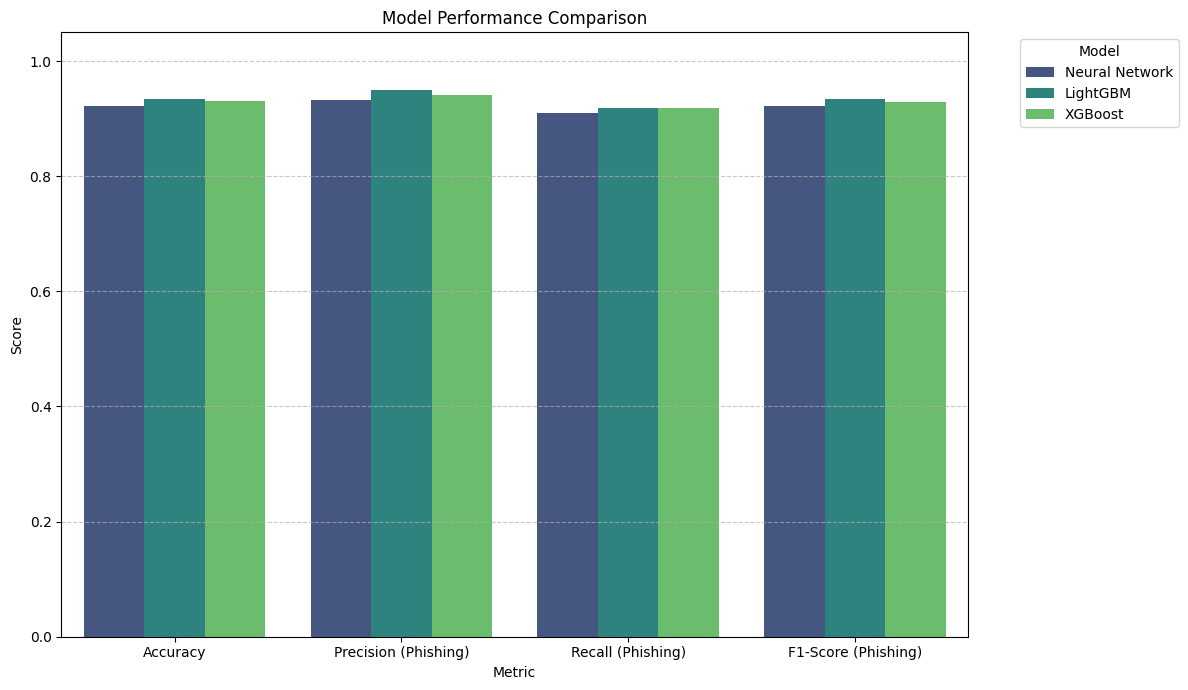

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming performance_summary_df is available from the previous evaluation step
if 'performance_summary_df' in locals():
    # Melt the DataFrame to long format for easier plotting
    df_melted = performance_summary_df.melt(
        id_vars='Model',
        var_name='Metric',
        value_name='Score'
    )

    # Define the metrics to plot
    metrics_to_plot = ['Accuracy', 'Precision (Phishing)', 'Recall (Phishing)', 'F1-Score (Phishing)']
    df_melted_filtered = df_melted[df_melted['Metric'].isin(metrics_to_plot)]

    # Create the grouped bar plot
    plt.figure(figsize=(12, 7))
    sns.barplot(
        x='Metric',
        y='Score',
        hue='Model',
        data=df_melted_filtered,
        palette='viridis'
    )

    plt.title('Model Performance Comparison')
    plt.ylabel('Score')
    plt.xlabel('Metric')
    plt.ylim(0, 1.05) # Set y-axis limit from 0 to 1.05 for scores
    plt.grid(axis='y', linestyle='--', alpha=0.7) # Add grid lines
    plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left') # Move legend outside
    plt.tight_layout() # Adjust layout to prevent labels overlapping
    plt.show()

else:
    print("Error: performance_summary_df not found. Please run the model evaluation cell first.")